# Emotion Detection from scratch

**Author:** Khush Joshi<br>
**Linkedin:** https://www.linkedin.com/in/khush-joshi-b4501724b/ <br>
**Description:** Training an image classifier from scratch on the Kaggle FER-2013 Dataset.

# Setting up Kaggle Directory

In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
100% 60.3M/60.3M [00:03<00:00, 23.1MB/s]
100% 60.3M/60.3M [00:03<00:00, 16.1MB/s]


In [ ]:
! unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [1]:
import numpy as np
import pandas as pd
import pathlib
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import imghdr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping ,ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,BatchNormalization ,MaxPooling2D ,Conv2D ,GlobalAveragePooling2D ,Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# Plotting random images from given directory

In [2]:
def see_data(path,num):
  files_name = random.sample(os.listdir(path),num)
  cols = 4
  rows = len(files_name)//cols + 1
  fig , ax = plt.subplots(rows,cols,figsize=(15,10))
  ax = ax.flatten()
  for i in range(num):
    file_path = os.path.join(path, files_name[i])
    img = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
    ax[i].imshow(img,cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(path.split("/")[-1])
  for j in range(num, len(ax)):
    ax[j].axis('off')
  plt.tight_layout()
  plt.show()


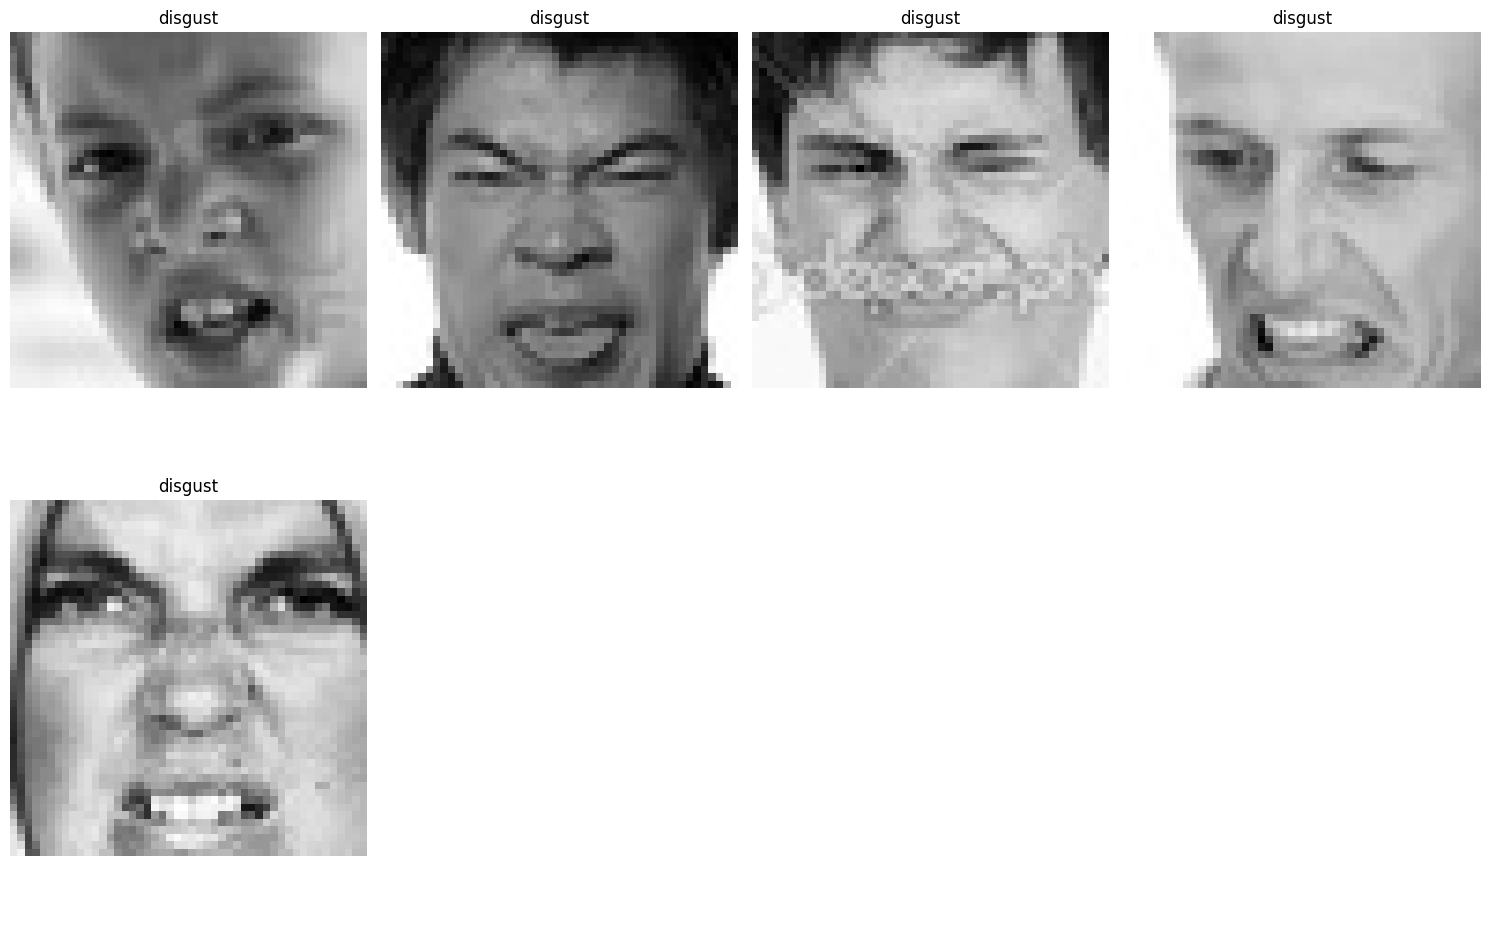

In [3]:
see_data("test/disgust",5)

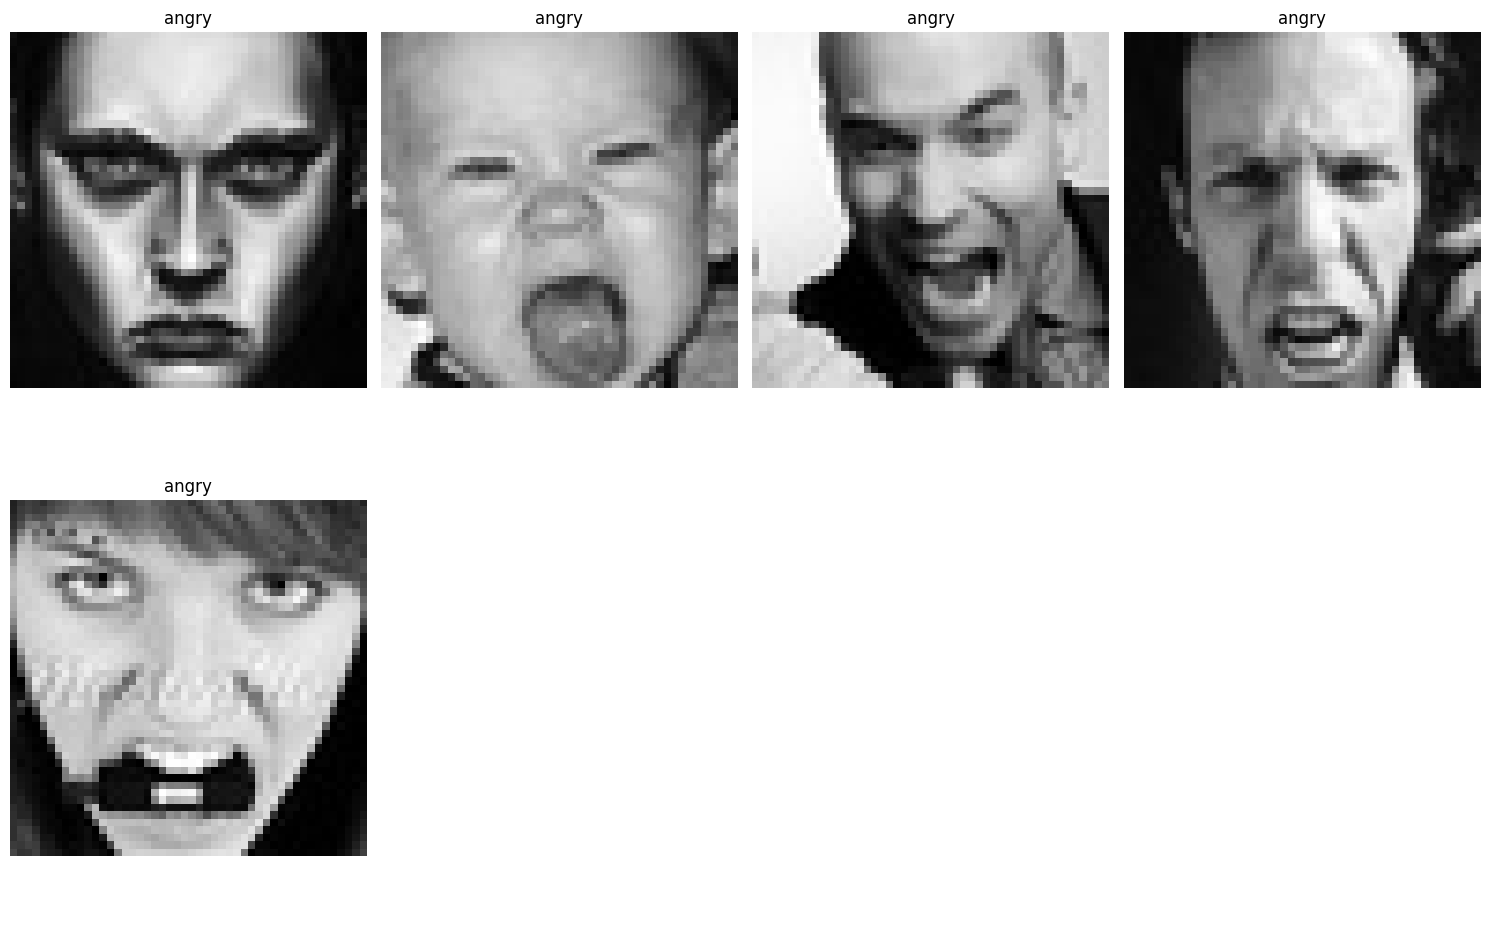

In [4]:
see_data("test/angry",5)

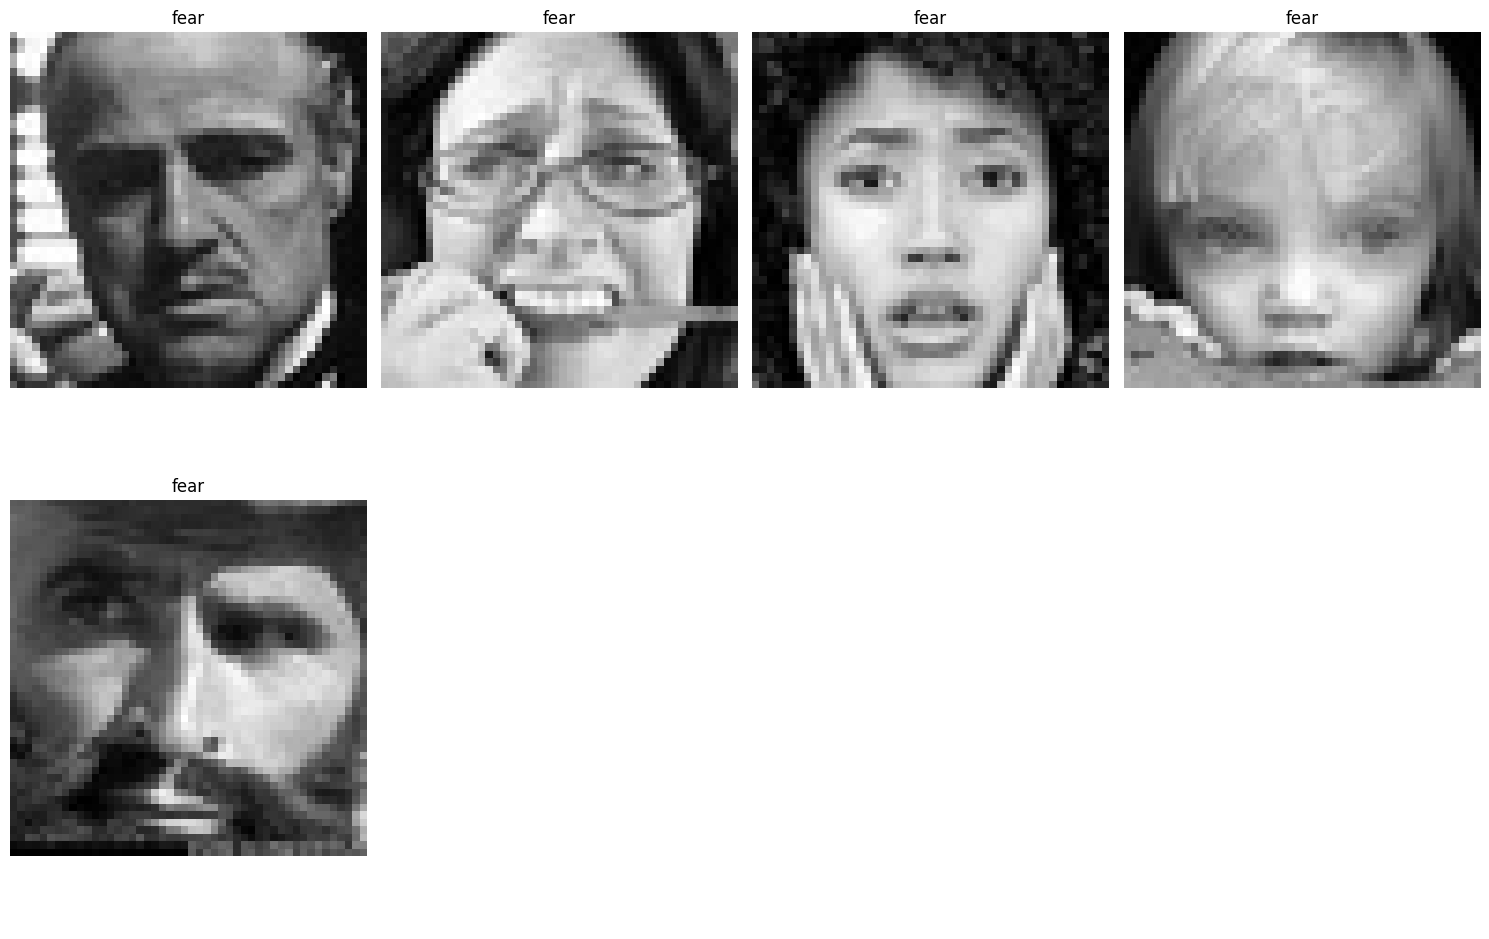

In [ ]:
see_data("test/fear",5)

# Removing Corrupted Images

In [5]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = 'train'

del_images = 0

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
  for file in files :
    file_path = os.path.join(root,file)
    file_type = imghdr.what(file_path)
    if file_type not in image_exts :
      os.remove(file_path)
      del_images += 1

print(f"number of images deleted {del_images}")


number of images deleted 0


# Data Analysis

In [6]:
data_dir_train = 'train/'
data_dir_test = 'test/'
values_train = {}
values_test = {}

for root, dirs, files in os.walk(data_dir_train):
  if files :
    values_train[root.split("/")[-1]] = [len(files)]

for root, dirs, files in os.walk(data_dir_test):
  if files :
    values_test[root.split("/")[-1]] = [len(files)]

df = pd.DataFrame(values_train,index=["train"])
df = pd.concat([df,pd.DataFrame(values_test,index=["test"])])
df


,angry,disgust,fear,happy,neutral,sad,surprise
train,3995,436,4097,7215,4965,4830,3171
test,958,111,1024,1774,1233,1247,831


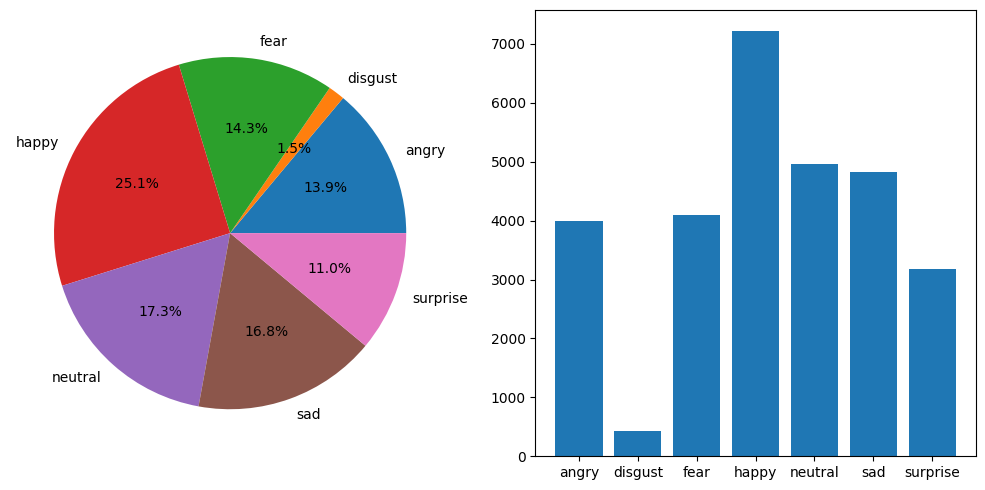

In [7]:
fig ,ax = plt.subplots(1,2,figsize=(10,5))

ax = ax.flatten()

ax[0].pie(df.iloc[0,:] , labels=df.iloc[0,:].index,autopct='%1.1f%%')
ax[1].bar(df.iloc[0,:].index,df.iloc[0,:].values)

plt.tight_layout()
plt.show()

**from above analysis we can conclude that the data is imbalanced**

# Building Model

# Model 1 : Custom CNN from Scratch Without data augmentation

### Callbacks

In [91]:
file_dir = "models/without_augmentation"
name = "CNN_without_aug.keras"
filepath = os.path.join(file_dir,name)

In [92]:
# Callback to save the model checkpoint
saving_model = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch',

)

In [93]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

In [94]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [95]:
# Aggregating all callbacks into a list
callbacks = [saving_model,earlystop,reduce_lr]

In [96]:
train_dir =  "train"
data_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_dir =  "test"
data_gen_test = ImageDataGenerator(rescale=1./255)

In [97]:
train_data_generator = data_gen.flow_from_directory(train_dir,target_size=(48, 48),
                                                    color_mode="grayscale",
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    batch_size=32,
                                                    subset="training"
                                                    )
validation_data_generator =  data_gen.flow_from_directory(train_dir,target_size=(48, 48),
                                                    color_mode="grayscale",
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    batch_size=32,
                                                    subset="validation"
                                                    )

test_data_generator = data_gen_test.flow_from_directory(test_dir,
                                                         target_size=(48, 48),
                                                         color_mode="grayscale",
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         batch_size=32,
                                                         subset=None)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [98]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(48,48,1),activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same',activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=L2(0.01),activation="relu"))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=L2(0.01),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=L2(0.01),activation="relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=L2(0.01),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(7,activation="softmax"))



In [99]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [100]:
# flow chart for CNN
path = 'FER_2013_Emotion_Detection/Custom_CNN_From_Scratch_without_Aug'
path = pathlib.Path(path)

# Create the directory and any necessary parent directories
path.mkdir(parents=True, exist_ok=True)
file_path = path / "Architecture.png"

plot_model(model, to_file = file_path,
           show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [101]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
history = model.fit(
    train_data_generator,
    epochs=15,
    validation_data=validation_data_generator,
    callbacks=callbacks)

Epoch 1/15
686/718 [===========================>..] - ETA: 1s - loss: 0.9511 - accuracy: 0.7543

KeyboardInterrupt: 

In [25]:
model = load_model("models\without_augmentation\CNN_without_aug.keras")

In [9]:
def plot_model_graph(history):
  fig , ax = plt.subplots(1,2,figsize=(15,5))
  ax = ax.flatten()

  val_loss = history["val_loss"]
  loss = history["loss"]

  val_acc = history["val_accuracy"]
  acc = history["accuracy"]

  ax[0].plot(val_loss,label="Validation_loss")
  ax[0].plot(loss,label="Training loss")
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Loss")
  ax[0].legend()

  ax[1].plot(val_acc,label="Validation accuracy")
  ax[1].plot(acc,label="Training accuracy")
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("accuracy")
  ax[1].legend()

  # Adjust layout to prevent overlap
  plt.tight_layout()
  plt.show()

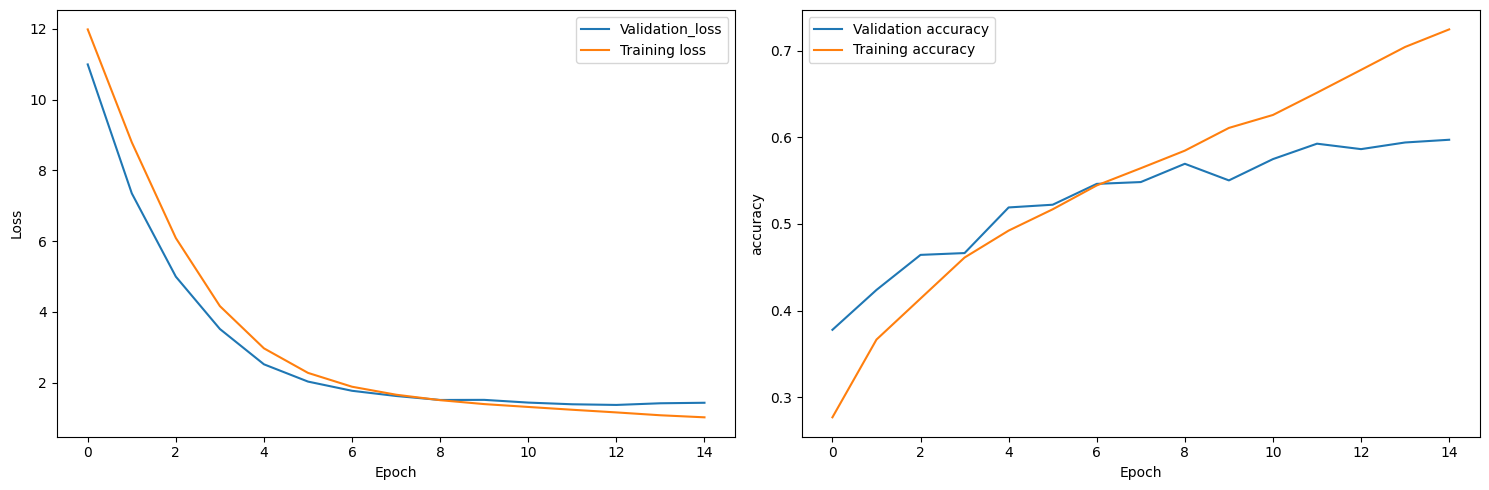

In [27]:
plot_model_graph(history.history)

In [28]:
test_loss , test_accu = model.evaluate(train_data_generator)
print("final Test accuracy = {:.2f}% , final test Loss = {:.2f}".format(test_accu*100, test_loss))

718/718 [==============================] - 8s 11ms/step - loss: 0.9531 - accuracy: 0.7813
final Test accuracy = 78.13% , final test Loss = 0.95


In [31]:
true_classes = train_data_generator.classes
predicted_classes = np.argmax(model.predict(train_data_generator),axis=1)
class_labels = list(train_data_generator.class_indices.keys())


718/718 [==============================] - 8s 11ms/step


In [32]:
cm = confusion_matrix(true_classes, predicted_classes)

In [8]:
def plot_confusion_matrix(cm):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="d", cmap="flare", xticklabels=class_labels, yticklabels=class_labels)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

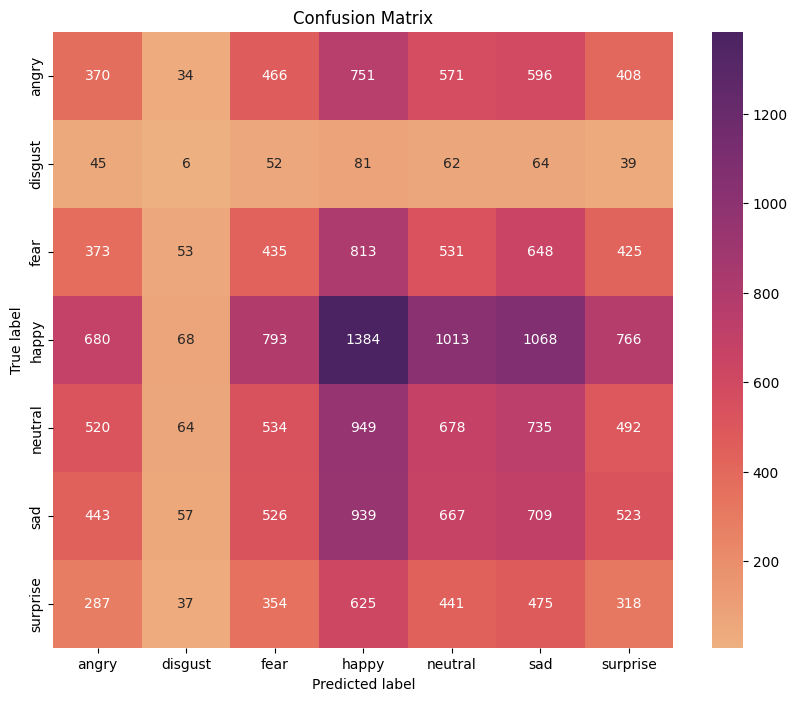

In [34]:
plot_confusion_matrix(cm)

In [35]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.12      0.13      3196
     disgust       0.02      0.02      0.02       349
        fear       0.14      0.13      0.14      3278
       happy       0.25      0.24      0.24      5772
     neutral       0.17      0.17      0.17      3972
         sad       0.17      0.18      0.17      3864
    surprise       0.11      0.13      0.12      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.17      0.17     22968



In [7]:
def prediction_output(num):
  images , labels = next(test_data_generator)
  images = images[0:num]
  labels = labels[0:num]
  named_labels = list(test_data_generator.class_indices)
  cols = 4
  rows = num//4 + (1 if num % 4 != 0 else 0)

  fig , ax = plt.subplots(rows,cols,figsize=(15,10))
  ax = ax.flatten()

  for i in range(num):
    ax[i].imshow(images[i])
    ax[i].axis('off')
    pridected_value = np.argmax(model.predict(np.expand_dims(images[i], axis=0)))
    named_value = named_labels[pridected_value]
    color = "green" if named_value == named_labels[np.argmax(labels[i])] else "red"

    ax[i].set_title(f"Actual : {named_labels[np.argmax(labels[i])]} \n Predicted : {named_value}",color = color)

  for i in range(num,rows*cols):
    ax[i].axis('off')

  plt.tight_layout()
  plt.show()



1/1 [==============================] - 0s 29ms/step


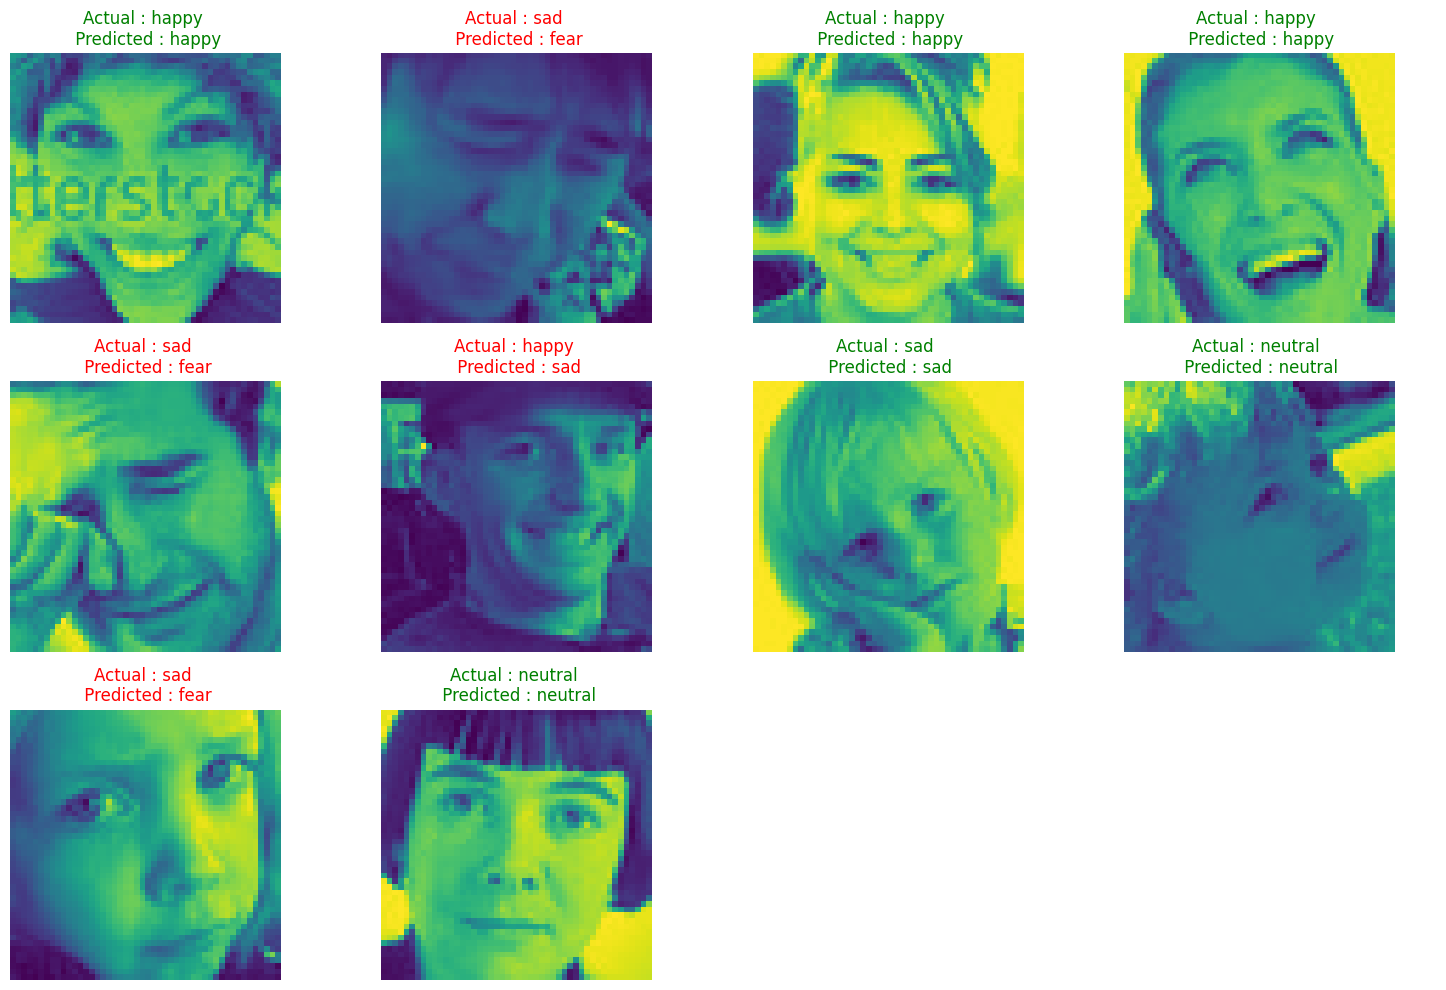

In [39]:
prediction_output(10)

# Model 2 : Custom CNN from Scratch With data augmentation

In [9]:
file_dir = "models/with_augmentation"
name = "CNN_with_aug.keras"
filepath = os.path.join(file_dir,name)

In [10]:
# Callback to save the model checkpoint
saving_model = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch',

)

In [11]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

In [12]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [13]:
# Aggregating all callbacks into a list
callbacks = [saving_model,earlystop,reduce_lr]

In [14]:
train_dir =  "train/"
data_gen = ImageDataGenerator(rescale=1./255,
                              validation_split=0.2,
                              horizontal_flip=True,
                              rotation_range=40,
                              shear_range=0.2,
                              zoom_range=0.2,
                              fill_mode='nearest',
                              width_shift_range=0.2,
                              height_shift_range=0.2
                              )
test_dir =  "test/"
data_gen_test = ImageDataGenerator(rescale=1./255)

In [15]:
train_data_generator = data_gen.flow_from_directory(train_dir,target_size=(48, 48),
                                                    color_mode="grayscale",
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    batch_size=32,
                                                    subset="training"
                                                    )
validation_data_generator =  data_gen.flow_from_directory(train_dir,target_size=(48, 48),
                                                    color_mode="grayscale",
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    batch_size=32,
                                                    subset="validation"
                                                    )

test_data_generator = data_gen_test.flow_from_directory(test_dir,
                                                         target_size=(48, 48),
                                                         color_mode="grayscale",
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         batch_size=32,
                                                         subset=None)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [48]:
## CNN model

model = Sequential()


# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(48,48,1),activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same',activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=L2(0.01),activation="relu"))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=L2(0.01),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=L2(0.01),activation="relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=L2(0.01),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(7,activation="softmax"))



In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)      

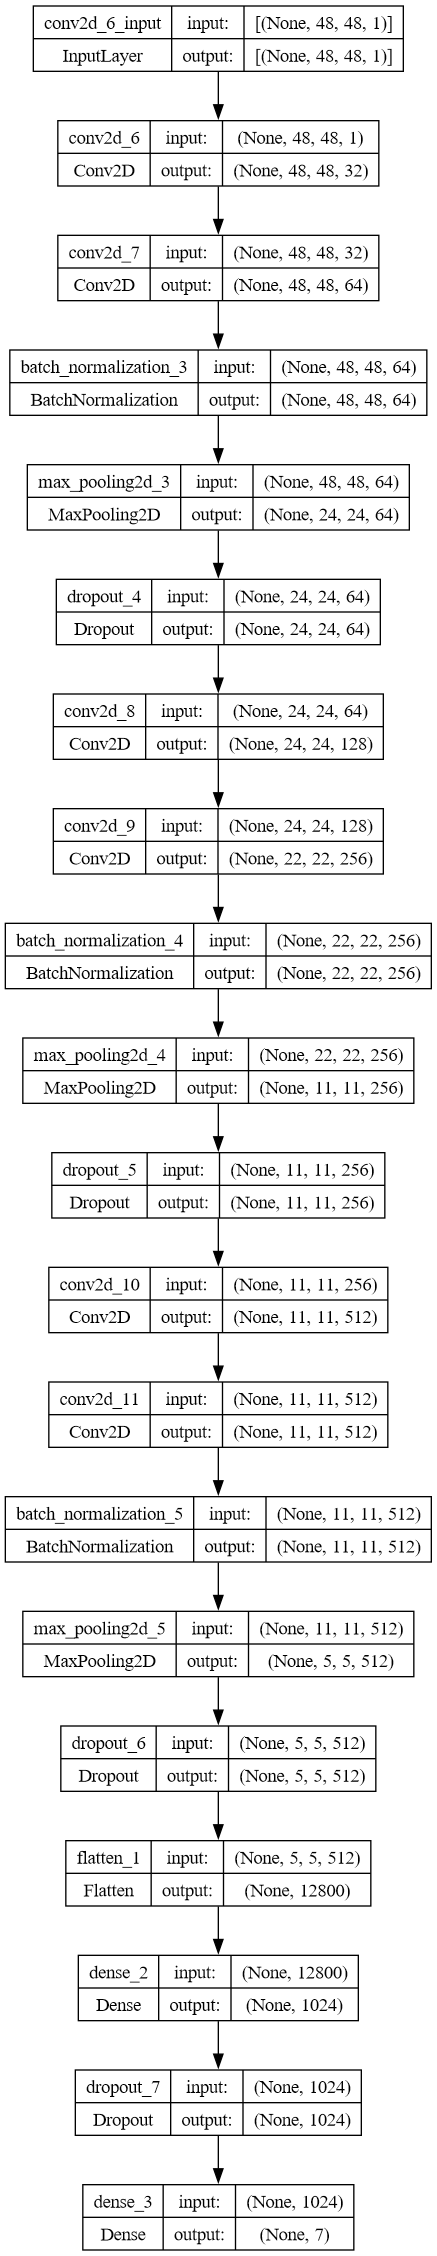

In [50]:
# flow chart for CNN
path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch_with_Aug'
path = pathlib.Path(path)

# Create the directory and any necessary parent directories
path.mkdir(parents=True, exist_ok=True)
file_path = path / "Architecture.png"

plot_model(model, to_file = file_path,
           show_shapes=True, show_layer_names=True)

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=["accuracy"],loss="categorical_crossentropy")

In [16]:
model = load_model("models\with_augmentation\CNN_with_aug.keras")

In [57]:
history = model.fit(train_data_generator,
    epochs=75,
    validation_data=validation_data_generator,
    callbacks=callbacks)

Epoch 1/75
717/718 [============================>.] - ETA: 0s - loss: 1.2637 - accuracy: 0.5428
Epoch 1: val_loss did not improve from 1.27986
718/718 [==============================] - 25s 35ms/step - loss: 1.2634 - accuracy: 0.5428 - val_loss: 1.2969 - val_accuracy: 0.5363 - lr: 4.0000e-06
Epoch 2/75
717/718 [============================>.] - ETA: 0s - loss: 1.2591 - accuracy: 0.5379
Epoch 2: val_loss improved from 1.27986 to 1.27675, saving model to models/with_augmentation\CNN_with_aug.keras
718/718 [==============================] - 25s 35ms/step - loss: 1.2590 - accuracy: 0.5380 - val_loss: 1.2767 - val_accuracy: 0.5489 - lr: 4.0000e-06
Epoch 3/75
717/718 [============================>.] - ETA: 0s - loss: 1.2595 - accuracy: 0.5402
Epoch 3: val_loss did not improve from 1.27675
718/718 [==============================] - 25s 34ms/step - loss: 1.2593 - accuracy: 0.5403 - val_loss: 1.2822 - val_accuracy: 0.5415 - lr: 4.0000e-06
Epoch 4/75
717/718 [============================>.] - ET

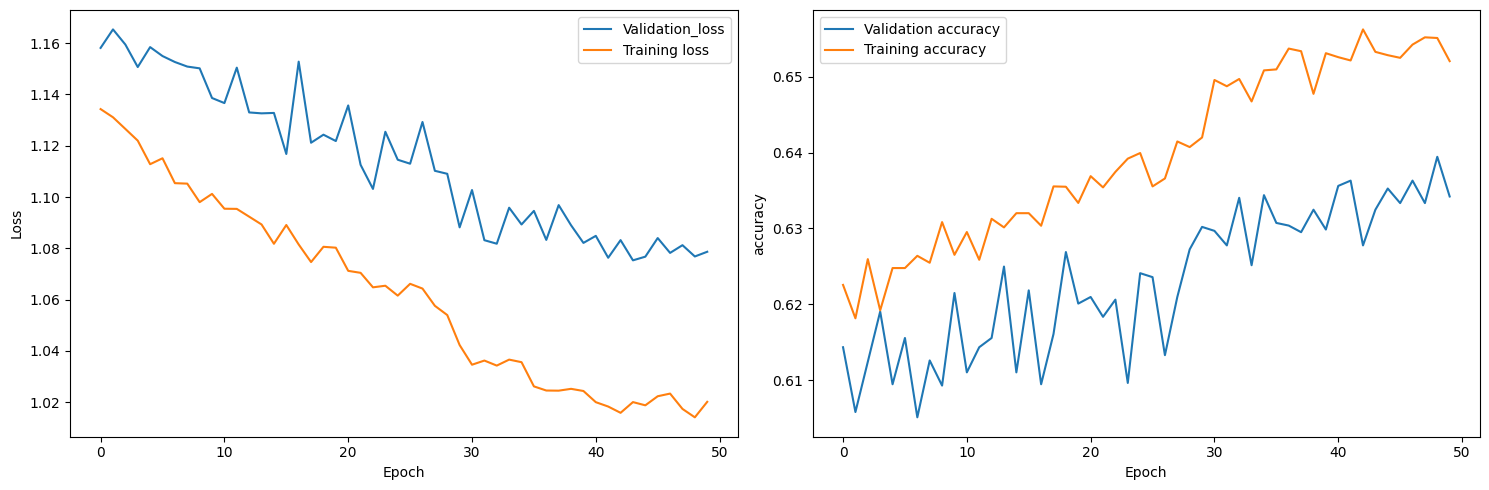

In [25]:
plot_model_graph(history.history)

In [17]:
test_loss , test_accu = model.evaluate(test_data_generator)
print("final Test accuracy = {:.2f}% , final test Loss = {:.2f}".format(test_accu*100, test_loss))

225/225 [==============================] - 15s 29ms/step - loss: 1.0206 - accuracy: 0.6541
final Test accuracy = 65.41% , final test Loss = 1.02


In [18]:
true_classes = train_data_generator.classes
predicted_classes = np.argmax(model.predict(train_data_generator),axis=1)
class_labels = list(train_data_generator.class_indices.keys())


718/718 [==============================] - 27s 37ms/step


In [28]:
cm = confusion_matrix(true_classes, predicted_classes)

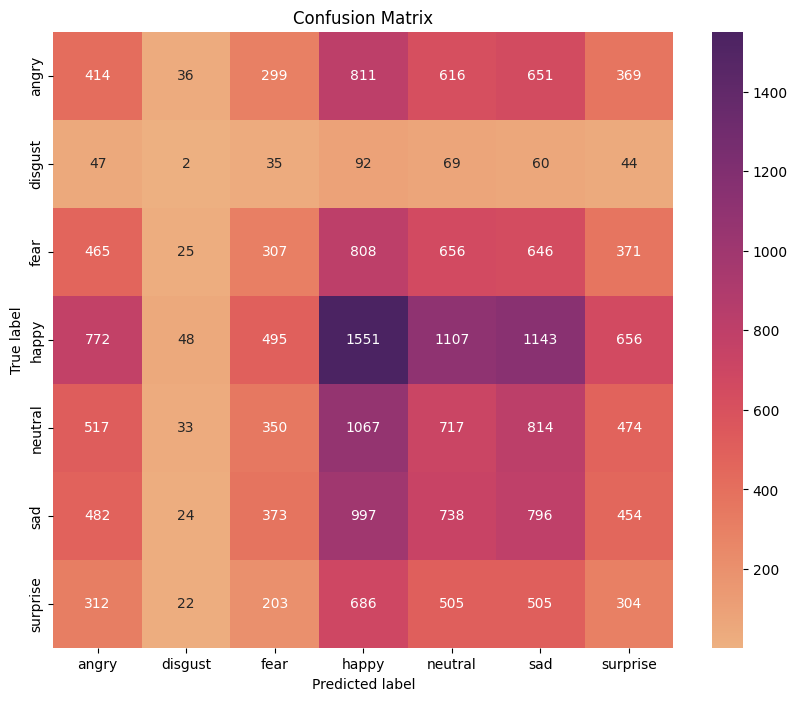

In [29]:
plot_confusion_matrix(cm)

In [20]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.13      0.13      3196
     disgust       0.02      0.01      0.01       349
        fear       0.15      0.10      0.12      3278
       happy       0.25      0.26      0.26      5772
     neutral       0.17      0.19      0.18      3972
         sad       0.17      0.20      0.19      3864
    surprise       0.11      0.11      0.11      2537

    accuracy                           0.18     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.18      0.17     22968



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


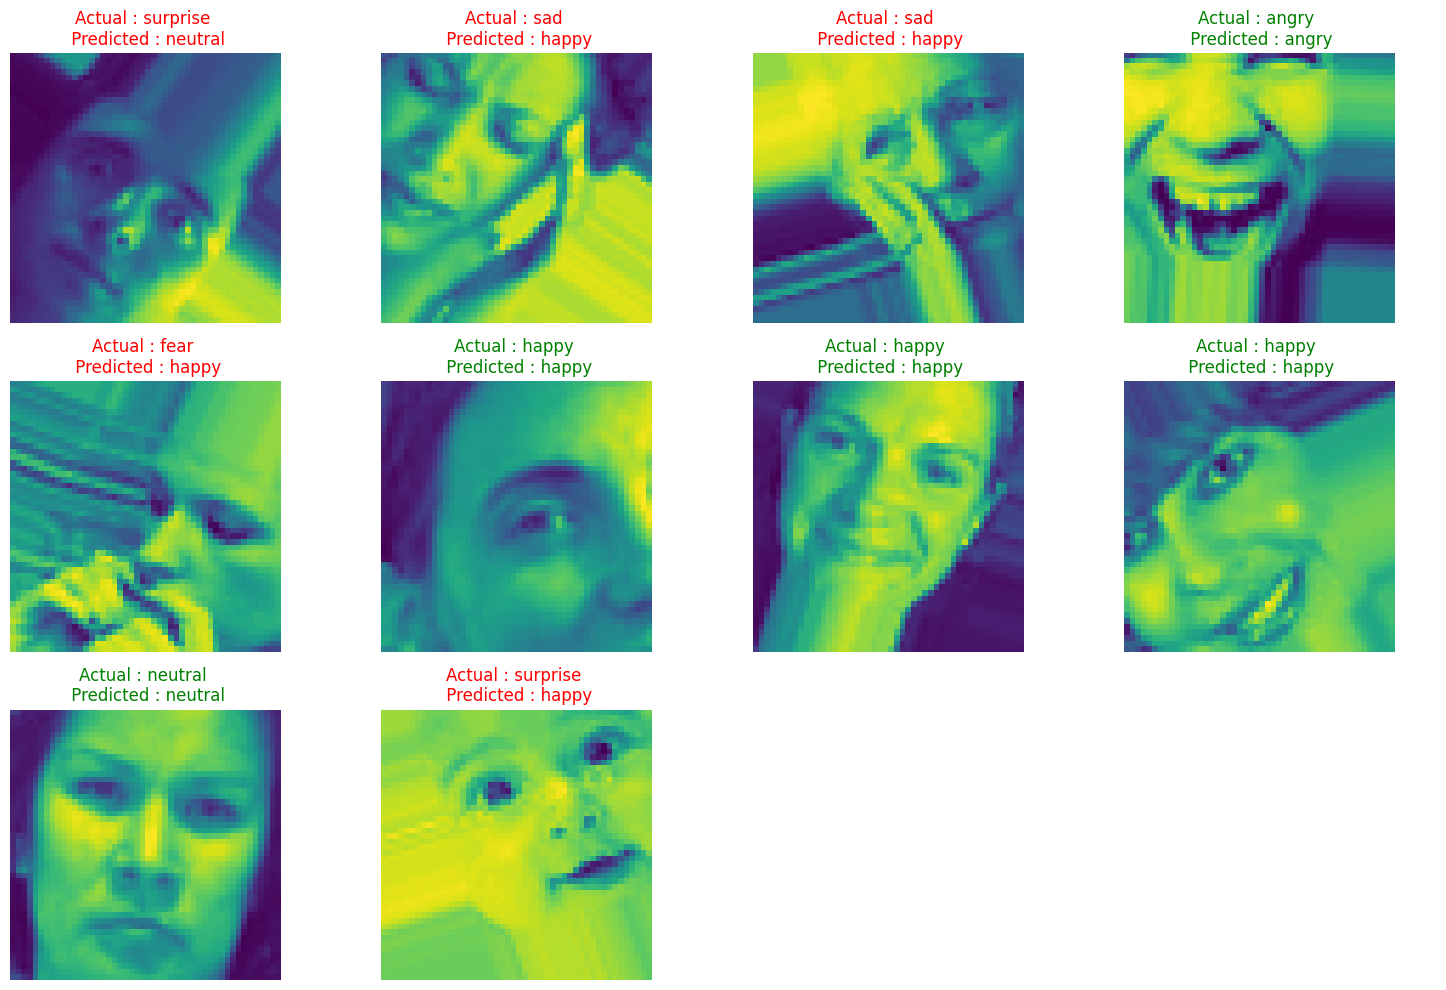

In [ ]:
prediction_output(10)

# Model 3: Transfer Learning VGGNET

In [26]:
file_dir = "models/VGG16"
name = "VGG16.keras"
filepath = os.path.join(file_dir,name)

In [27]:
# Callback to save the model checkpoint
saving_model = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch',

)

In [28]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

In [29]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [30]:
# Aggregating all callbacks into a list
callbacks = [saving_model,earlystop,reduce_lr]

In [31]:
train_dir =  "train"
data_gen = ImageDataGenerator(rescale=1./255,
                              validation_split=0.2,
                              horizontal_flip=True,
                              rotation_range=40,
                              shear_range=0.2,
                              zoom_range=0.2,
                              fill_mode='nearest',
                              width_shift_range=0.2,
                              height_shift_range=0.2
                              )
test_dir =  "test"
data_gen_test = ImageDataGenerator(rescale=1./255)

In [32]:
train_data_generator = data_gen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    batch_size=32,
                                                    subset="training"
                                                    )
validation_data_generator =  data_gen.flow_from_directory(train_dir,
                                                          target_size=(224, 224),
                                                          color_mode="rgb",
                                                          class_mode='categorical',
                                                          shuffle=True,
                                                          batch_size=32,
                                                          subset="validation"
                                                    )

test_data_generator = data_gen_test.flow_from_directory(test_dir,
                                                         target_size=(224, 224),
                                                         color_mode="rgb",
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         batch_size=32,
                                                         subset=None)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [38]:
x = vgg.output
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax', kernel_initializer='glorot_normal')(x)

# Define the model
model = Model(inputs=vgg.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [39]:
# Introducing Class wieghts for imbalanced data
classes = np.array(train_data_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [39]:
model = load_model("models\VGG16\VGG16.keras")

In [40]:
history = model.fit(train_data_generator,
                    validation_data=validation_data_generator,
                    epochs=50,
                    class_weight = class_weights_dict,
                    callbacks = callbacks)

Epoch 1/50
718/718 [==============================] - ETA: 0s - loss: 1.0219 - accuracy: 0.5760
Epoch 1: val_loss did not improve from 1.19578
718/718 [==============================] - 163s 226ms/step - loss: 1.0219 - accuracy: 0.5760 - val_loss: 1.2088 - val_accuracy: 0.5457 - lr: 4.0000e-06
Epoch 2/50
166/718 [=====>........................] - ETA: 1:37 - loss: 1.0329 - accuracy: 0.5787

KeyboardInterrupt: 

In [37]:
# flow chart for CNN
path = 'FER_2013_Emotion_Detection/Custom_CNN_From_Scratch_transfer_learning'
path = pathlib.Path(path)

# Create the directory and any necessary parent directories
path.mkdir(parents=True, exist_ok=True)
file_path = path / "Architecture.png"

plot_model(model, to_file = file_path,
           show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


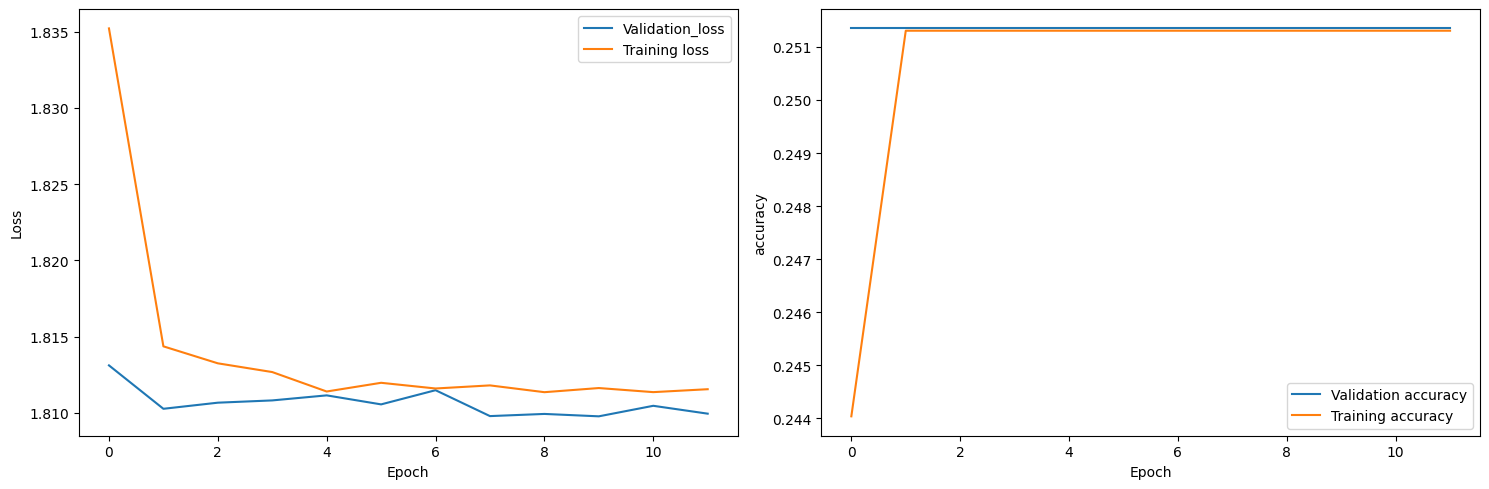

In [ ]:
plot_model_graph(history.history)

In [ ]:
test_loss , test_accu = model.evaluate(test_data_generator)
print("final Test accuracy = {:.2f}% , final test Loss = {:.2f}".format(test_accu*100, test_loss))

225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.2461 - loss: 1.8198
final Test accuracy = 24.71% , final test Loss = 1.81


In [ ]:
true_classes = train_data_generator.classes
predicted_classes = np.argmax(model.predict(train_data_generator),axis=1)
class_labels = list(train_data_generator.class_indices.keys())


718/718 ━━━━━━━━━━━━━━━━━━━━ 262s 364ms/step


In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)

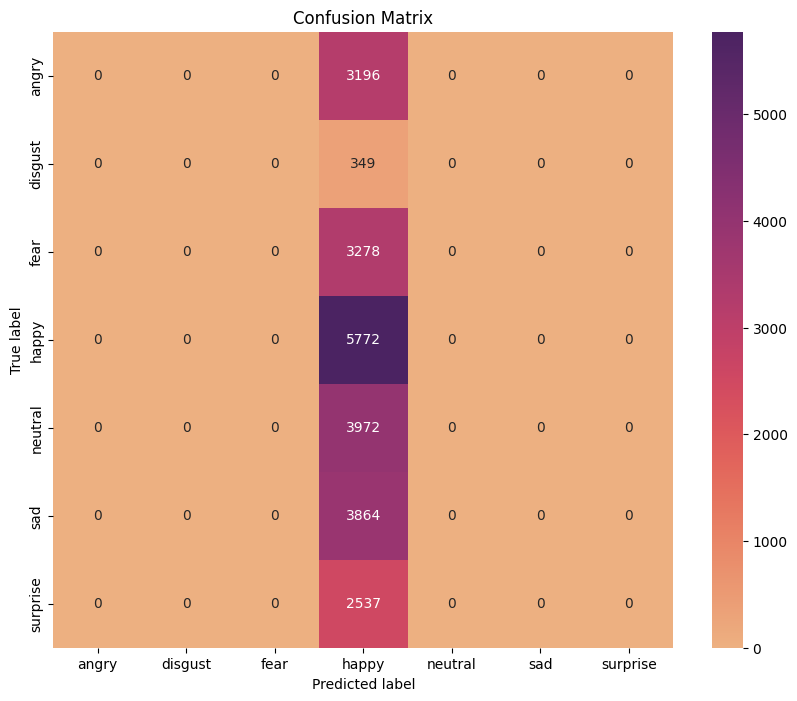

In [ ]:
plot_confusion_matrix(cm)

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00      3196
     disgust       0.00      0.00      0.00       349
        fear       0.00      0.00      0.00      3278
       happy       0.25      1.00      0.40      5772
     neutral       0.00      0.00      0.00      3972
         sad       0.00      0.00      0.00      3864
    surprise       0.00      0.00      0.00      2537

    accuracy                           0.25     22968
   macro avg       0.04      0.14      0.06     22968
weighted avg       0.06      0.25      0.10     22968



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


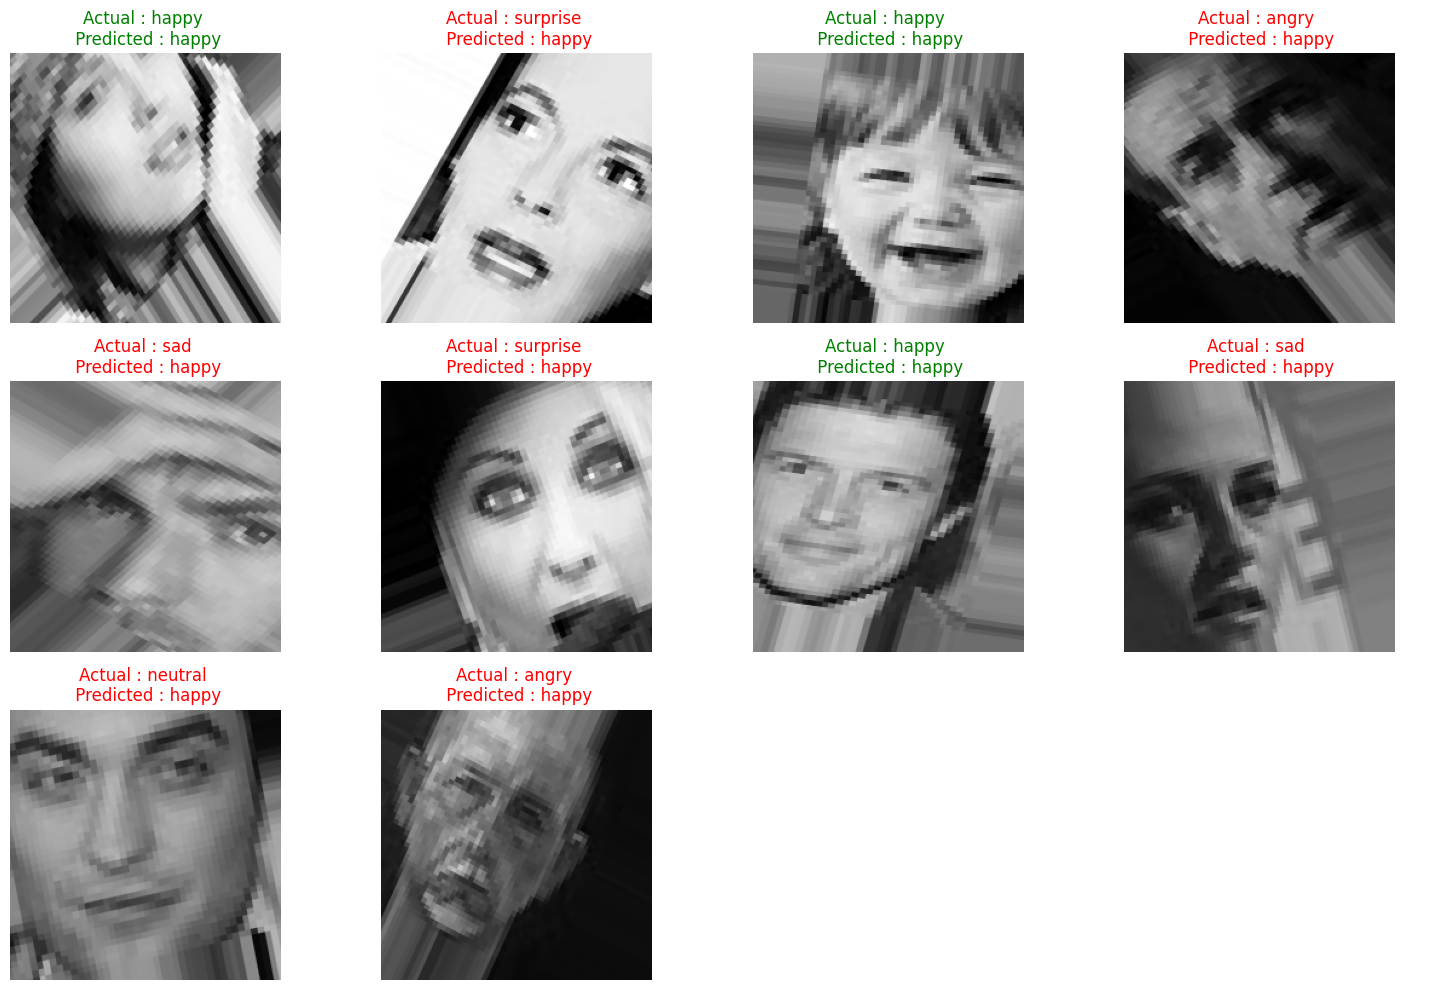

In [ ]:
prediction_output(10)

# Model : Transfer Learning ResNet50

In [40]:
file_dir = "models/ResNet50"
name = "ResNet50.keras"
filepath = os.path.join(file_dir,name)

In [41]:
# Callback to save the model checkpoint
saving_model = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch',

)

In [42]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

In [43]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [44]:
# Aggregating all callbacks into a list
callbacks = [saving_model,earlystop,reduce_lr]

In [47]:
train_dir =  "train"
data_gen = ImageDataGenerator(rescale=1./255,
                              validation_split=0.2,
                              horizontal_flip=True,
                              rotation_range=40,
                              shear_range=0.2,
                              zoom_range=0.2,
                              fill_mode='nearest',
                              width_shift_range=0.2,
                              height_shift_range=0.2
                              )
test_dir =  "test"
data_gen_test = ImageDataGenerator(rescale=1./255)

In [72]:
train_data_generator = data_gen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    batch_size=64,
                                                    subset="training"
                                                    )
validation_data_generator =  data_gen.flow_from_directory(train_dir,
                                                          target_size=(224, 224),
                                                          color_mode="rgb",
                                                          class_mode='categorical',
                                                          shuffle=True,
                                                          batch_size=64,
                                                          subset="validation"
                                                    )

test_data_generator = data_gen_test.flow_from_directory(test_dir,
                                                         target_size=(224, 224),
                                                         color_mode="rgb",
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         batch_size=64,
                                                         subset=None)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [73]:
# Introducing Class wieghts for imbalanced data
classes = np.array(train_data_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [74]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [75]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [77]:
x = Flatten()(base_model.output)

x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x)
x= Dense(256, activation='relu')(x)
x= Dropout(0.1)(x)
x= Dense(128, activation='relu')(x)
x= Dropout(0.1)(x)
x=Dense(7, activation='softmax')(x)


In [78]:
model = Model(inputs = base_model.input , outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [79]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
# !gdown --id 1DB4YaPPfbeoqJUnewZTD8TIlkiKboZer

In [81]:
# model = load_model("/content/ResNet50.keras")
# from tensorflow.keras import backend as K
# K.clear_session()
# from tensorflow.keras import mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

In [82]:
history = model.fit(
                    train_data_generator,
                    epochs=40,
                    validation_data=validation_data_generator,
                    class_weight=class_weights_dict,
                    callbacks = callbacks)

Epoch 1/40


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2_block2_preact_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\khush\AppData\Local\Temp\ipykernel_34088\2298020431.py", line 1, in <module>
      history = model.fit(
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\khush\miniconda3\envs\tf-gpu\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/conv2_block2_preact_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[64,256,56,56] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2_block2_preact_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_116540]